**Problem:- Sementic Segmentation for celebrity faces**<br>
Given the images of celebrity faces, produce a segmentation mask that can help to differentiate various facial attributes such as eyes, hair, nose etc. 

**Provided Solution**<br>
This notebook uses U-Net as a model and EfficientNetb0 as backbone

**Reason**<br>
The choice of this architecture is based on the experimentation done by me as part of my final year project: https://www.ijert.org/research/extraction-of-road-network-from-satellite-images-using-efficient-net-IJERTV9IS070622.pdf<br>
The reason to choose U-net is because even though it is heavily parameterized architecture compared to Linknet and FPN, its performance is better than others.<br>
The reason to choose Efficientnet as backbone is that it has reasonable parameters and for my study the performace difference was neglible than its resnet counterparts

**Disclaimer**
<ol>
<li>Please do not run this notebook first if you want to verify the my output as the training time is high. </li>
<li>Please make sure the dataset paths are correct according to stored files </li>
<li>The dataset is partitioned into train, validation and test on local machine for convinence.Refer this link https://github.com/switchablenorms/CelebAMask-HQ/tree/master/face_parsing for partition code or ping me for sharing the dataset </li>
<li>You may have to reload once or twice while loading the dataset initially (I think its because in the initial runs, the data is transfered from drive to temporary storage of colab) since it will give an input output error. Reloading and running again will solve the problem </li>



</ol>

**Semantic Segmentation as a task**<br>
As seen below are the few common tasks in computer vision. Simplist of all is classification which only tells which object is present in the image but tells nothing about its location<br>
Next is the task of object detection which is responsible for not only identifying the object in the image, but also giving the location of object in the image with the help of bounding box<br>
The third task is semantic segmentation, which we will be performing in this experiment. It can be simply thought of as pixel wise classification such as whether a pixel belongs to background, sky, grass, cat etc. It is an expensive task but gives us a lot of information for some downstream activity and is also being used in applications such as self driving cars<br>
Instance segmentation is quite similar to semantic segmentation, the difference being it identifies  different instances of objects that are close together instead of treating them as a single Blob.


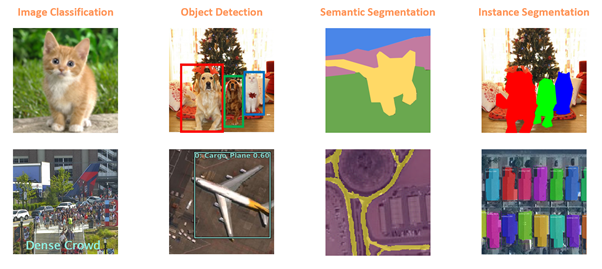

**Two commonly used approaches for semantic segmentation**<br>
In the first approach, we use a fully convolution neural network which actually computes probability values for each pixels. Not used aggresively these days<br>
The second approach is an encoder-decoder architecture, where the image is first downsampled using CNN into a context vector that captures semantic value from the input image, and this context vector is upsampled to generate the semantic mask

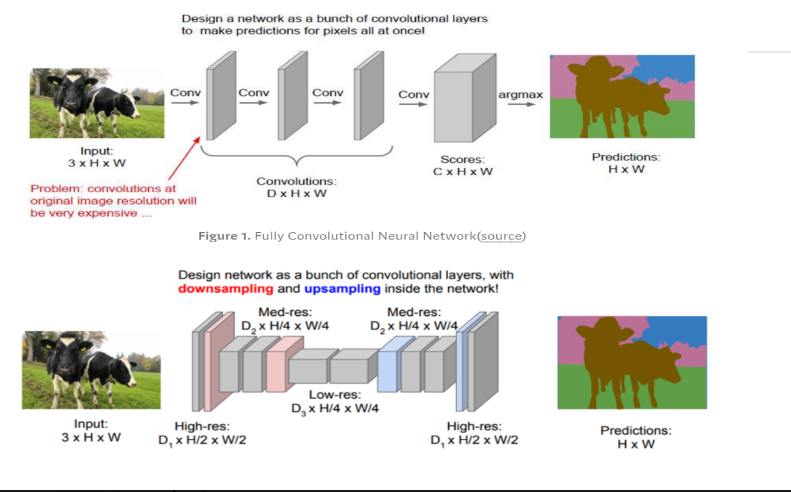

**Please install the following libraries for this code to work**

In [ ]:
# Responsible for Data Augmentation
!pip install imgaug

In [ ]:
# Recommeded to use this version with segmentation models library
!pip install tensorflow-gpu==2.2.0

In [ ]:
# Had to try something from NeurIPS 2020
# Details of the optimizer explained Below
!pip install adabelief-tf==0.1.0

     |████████████████████████████████| 460kB 16.4MB/s 
     |████████████████████████████████| 10.6MB 36.6MB/s 
ERROR: tensorflow-gpu 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


In [ ]:
# Awesome library consisting of various methodologies that helps us use pretrained 
# models for semantic segmentation.
# Refer this link for more details
# https://segmentation-models.readthedocs.io/en/latest/index.html

!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
# segmentation models will look for keras instead of tf.keras if we do not specify this 
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
# Mount google Drive to access files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
import random as rn
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
# Check Tensorflow Version

tf.__version__

'2.2.0'

In [ ]:
# Directory where all data is stored.
# Please change this according to your directory structure if you want to rerun

DATA_DIR='drive/MyDrive/Fynd/'

In [ ]:
# Dataset already split into train, validation and test data
# Please use this link for partitioning the face data
# https://github.com/switchablenorms/CelebAMask-HQ/tree/master/face_parsing
# Exact same procedure is followed, first run  g_mask.py which is reponsible to 
# combines all the classes into a single mask image; values between 0-18
# The class encoding is also available on the same link provided above.
# Then run theg_partition.py to split data into train, valid and test set
# Train set- 24183 images and masks
# Validation set -2993 images and masks
# Test set - 2824 images and masks
# Total Images and masks-30000

 
x_train_dir = os.path.join(DATA_DIR, 'train_img_zip/train_img')
y_train_dir = os.path.join(DATA_DIR, 'train_label_zip/train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val_img')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

x_test_dir = os.path.join(DATA_DIR, 'test_img')
y_test_dir = os.path.join(DATA_DIR, 'test_label')

In [ ]:
# As the dataset is large, only 4 augmentations are used for this experiment
# Refered this excellent blog for ideas.
# https://manmeet3.medium.com/face-data-augmentation-techniques-ace9e8ddb030


# Choosing Greyscale augmenation is loosely based on idea of colorization in 
# self supervised setting so that the output does not heavily rely on color 
# channels only but also other attributes in the image (My intuition)
# https://openaccess.thecvf.com/content_ECCV_2018/papers/Carl_Vondrick_Self-supervised_Tracking_by_ECCV_2018_paper.pdf
# Applied only to image
aug2 = iaa.color.Grayscale()

# Most Common Data Augmentation, Left to right more likely then up to down in 
# face images. Applied to both Image and Mask
aug3 = iaa.Fliplr(1)

# Gaussian Noise always needed, per channel enables to add seperate noise to each
# RGB channels. Applied to input image only
aug4 = iaa.AdditiveGaussianNoise(scale=0.1*255,per_channel=True)

# Motion Blur is kind of blur that can occur in real life
# https://medium.com/microsoft-design/science-in-the-system-how-blur-effects-work-8b0590996e09#:~:text=There%20are%20two%20types%20of,movement%2C%20creating%20a%20motion%20trail.
# Applied to input image only
aug5 = iaa.blur.MotionBlur()

In [ ]:
# This function helps in Visualizing Images
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# Classes for DataLoading 
class Dataset:
      # 19 classes from 0-18
      CLASSES = [ 'background','skin','nose', 'eye_g','l_eye', 
                 'r_eye','l_brow','r_brow','l_ear','r_ear','mouth', 'u_lip', 
                 'l_lip','hair','hat', 'ear_r','neck_l','neck','cloth'
                 ]

      def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            train=False, 
            
            ):
        # Sampling 5000 samples randomly from the training set since it is very 
        # difficult to train 24000 images on colab. Tried it, crashed after 4 hrs in first epoch
        # So thought sampling would be better
        # Just use the else part for training samples as well to use whole training data
        if train:
          self.ids=rn.sample(range(24180),5000)
          # Retrieve all images that are given in self.ids
          self.images_fps = [os.path.join(images_dir, str(image_id)+'.jpg') for image_id in self.ids]

          # Retrieve all mask images that are given in self.ids
          self.masks_fps = [os.path.join(masks_dir, str(image_id)+'.png') for image_id in self.ids]
        else:
          # Retrieve Image ids list
          self.ids = os.listdir(images_dir)

          # Retrieve all images that are given in self.ids
          self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

          # Retrieve all mask images that are given in self.ids
          self.masks_fps = [os.path.join(masks_dir, image_id[:-3]+'png') for image_id in self.ids]
        
        
        
        


        # Retrieve all the class values (Indices of class names provided) in the argument
        # For example if ['background','nose'] is passed in class arguments, it will 
        # return [0,2]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.train = train
        
       
      
      def __getitem__(self, i):
        '''This function is used to retrieve image and corrosponding mask'''
        
        # read data
        image = cv2.imread(self.images_fps[i])
        
        # cv2 reads image in BGR format, convert it to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Since input size is 1024x1024 and output size is 512; resize input to 512 
        image=cv2.resize(image,(512,512))

        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # extract certain classes from mask (e.g. nose)
        # This is equivalent to one hot encoding masks
        # Meaning each class has its seperate bit plane
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
                
        # If train is True
        if self.train:
          # Sample value from uniform distribution
          a = np.random.uniform()
          
          # Likelihood of every augmentation is roughly 20%
          # Like a Bernoulli Distribution
          if a<0.2:
              # Greyscale
              image = aug2.augment_image(image)
              mask = mask

          elif a<0.4:
              # Fliplr
              image = aug3.augment_image(image)
              mask = aug3.augment_image(mask)

          elif a<0.6:
              # Gaussian Noise
              image = aug4.augment_image(image)
              mask = mask

          elif a<0.8:
              # Motion Blur
              image = aug5.augment_image(image)
              mask = mask
          else:
              # Actual Image without augmentations
              image = image
              mask = mask
        
        return image, mask
        
      def __len__(self):
        return len(self.ids)
        
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] 

        # Tuple required for TF>=2.2       
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Try class dataset on training set
dataset = Dataset(x_train_dir, y_train_dir, classes=['background','hair','nose','neck'],train=True)

In [ ]:
# Retrive one sample from training set.
image, mask = dataset[100]

In [ ]:
# Face Image size is 512x 512x3
image.shape

(512, 512, 3)

In [ ]:
# Corrosponding mask shape is 512x512xNo. of classes
mask.shape

(512, 512, 4)

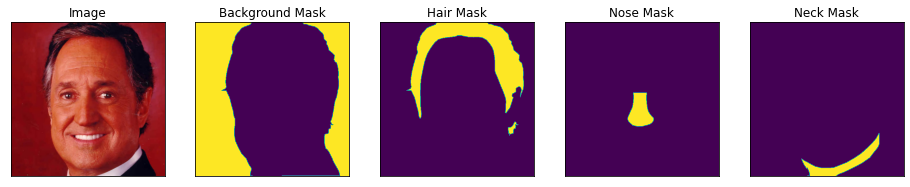

In [ ]:
# Visualize each class seperately
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    hair_mask=mask[..., 1].squeeze(),
    nose_mask=mask[..., 2].squeeze(),
    neck_mask=mask[..., 3].squeeze(),

    )

In [ ]:
dataset.__len__()

5000

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Check whether segmentation models is using tf.keras and not keras
sm.framework()

'tf.keras'

In [ ]:
# Backbone choice explained in Introducation
BACKBONE = 'efficientnetb0'

# Maximum size possible without Resource Exhausation Error
BATCH_SIZE = 8

CLASSES = [ 'background','skin','nose', 'eye_g','l_eye', 
                'r_eye','l_brow','r_brow','l_ear','r_ear','mouth', 'u_lip', 
                'l_lip','hair','hat', 'ear_r','neck_l','neck','cloth'
                ]
EPOCHS = 3


In [ ]:
# Number of Classes
n_classes = len(CLASSES)
n_classes

19

**U-net**<br>
Before understanding U-net, we need to understand two terminologies, model and backbone. Model here can be thought of the scaffolding or flow of the network whereas the backbone is the CNN architecture used in the network as encoder.<br>
U-net is one of the most commonly used architecture for semantic segmentation.The working of U-Net is as follows:<br>
<ol>
<li>Initially, the image is convolved and passed through max pooling as shown in the figure.</li>
<li>Continuing step 1 iteratively leads us to a context representation of 28x28x1024</li>
<li>This vector represents end of encoder and start of decoder</li>
<li>After this we Upsample; while upsampling we concat the upsampled vector in decoder with corrosponding part from encoder with the help of copy and crop</li>
<li>We continue this process till we get a semantic map; for smenatic map we use N 1x1 convolutions for channel reduction</li>

<ol>

For detailed explaination of U-Net refer:-https://arxiv.org/pdf/1505.04597.pdf

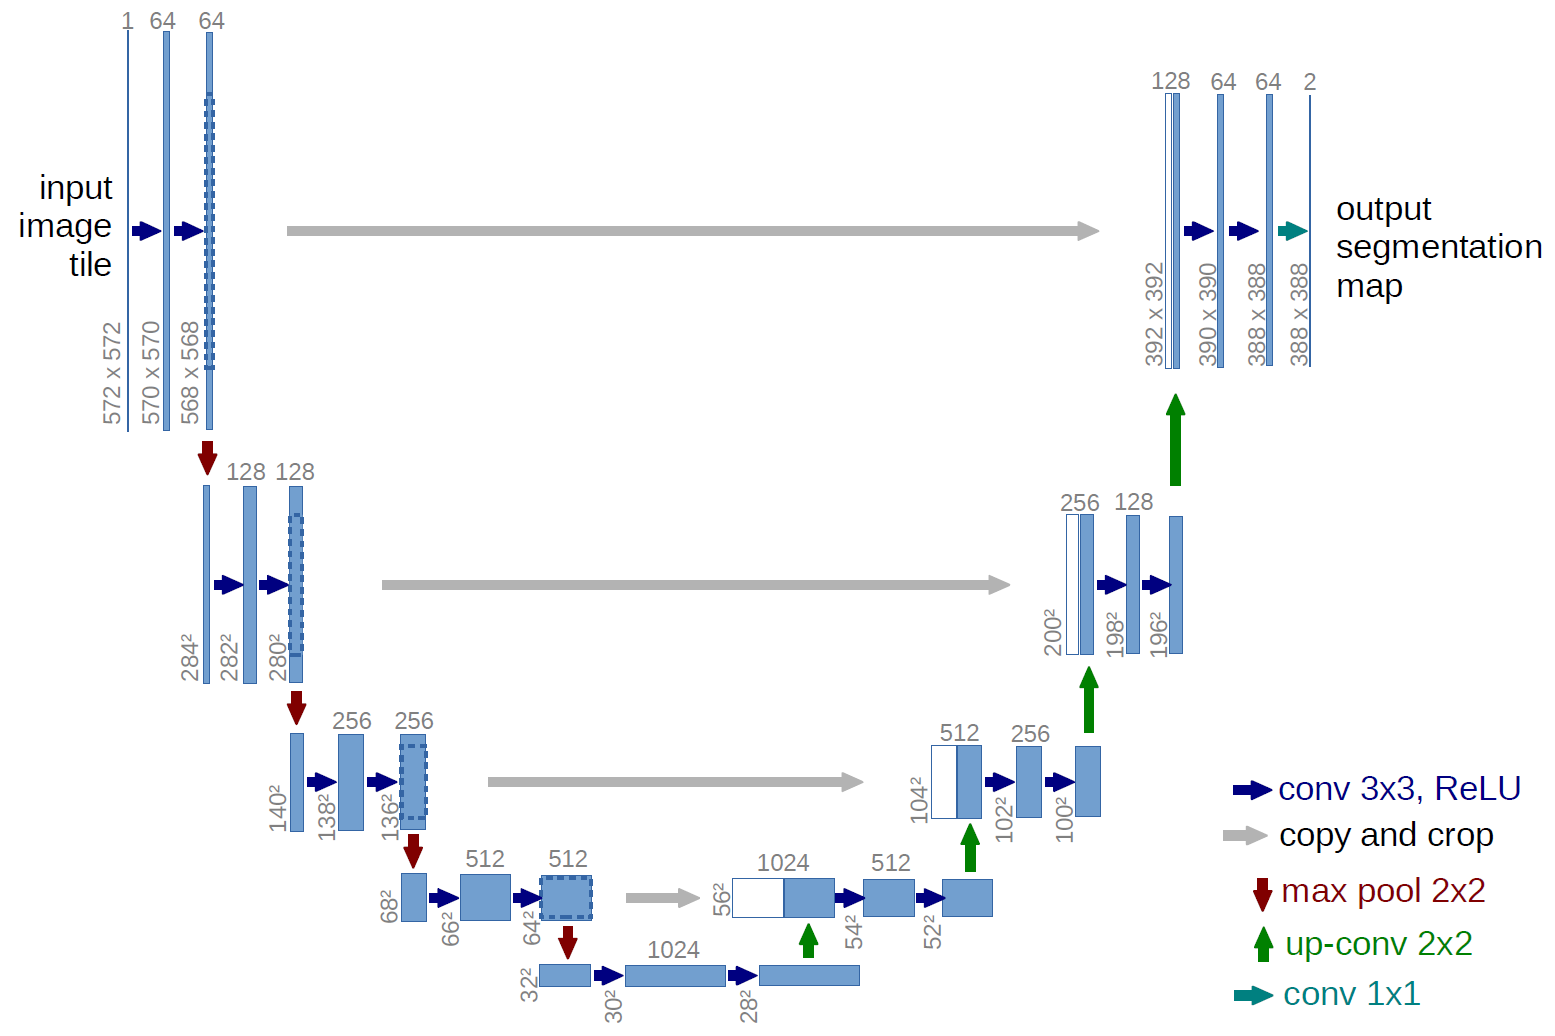

**EfficientNet**<br>
EfficientNet is a recent architecture that came into limelight. Its main intention was to achieve efficiency and scalability along with accuracy.The architecture came with a concept of compound scaling which is a systematic way to design your Neural Network. There are essentially three common ways to scale your architecture scaling of depth as deeper architectures tend to give better results than their shallow counterparts(though the gains are sort off sub-linear). Same scaling with width that can be analogous to comparision between Resnet and WideResnet. Thirdly Resolution scaling as higher resolution has greater details and will require deeper networks to capture the effective receptive field. All the other methods are experimented emperically for what works best and there has not been any scaling mechanism that has being used. Efficientnet showed that rather than scaling in one dimension, we should systematically scale in all three dimensions.This is known as compund scaling. Here systematically means they came up with a formulation using Neural Architecture Search that works well. The efficiency in efficientnet is attributed to various components in the architecture, for example the Depthwise Convolution that reduces great number of paramters. 

Efficientnet paper from Google AI:- https://arxiv.org/pdf/1905.11946.pdf<br>
My final year project was based on similar study:https://www.ijert.org/research/extraction-of-road-network-from-satellite-images-using-efficient-net-IJERTV9IS070622.pdf <br>
Finally excellent video by Rahul Deora: https://www.youtube.com/watch?v=IBndcd4UfTs

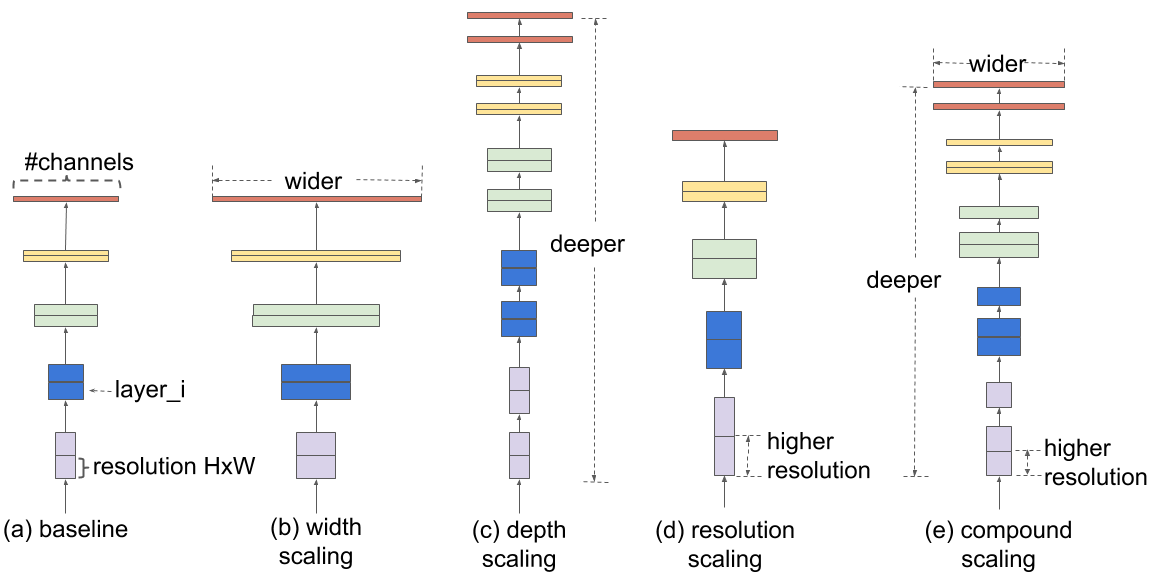

In [ ]:
# Load Unet model from segmentaion models library with Efficientnetb0 as backbone
# Number of classes=19 and activation is softmax since it is multiclass classification
# Initialize Encoder weights as Imagenet to enable some transfer learning
# Even if downstream task is different, the weights for initial layers which are
# Gabor Like filters is a useful transfer of knowledge 
# Encoder is not frozen for end to end training

model = sm.Unet(BACKBONE, classes=n_classes, activation='softmax',encoder_weights='imagenet',input_shape=(512,512,3))

In [ ]:
# If previous trained model weights for this task are available, then use those weights
if os.path.isfile('./best_model.h5'):
  model.load_weights('./best_model.h5')

In [ ]:
# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

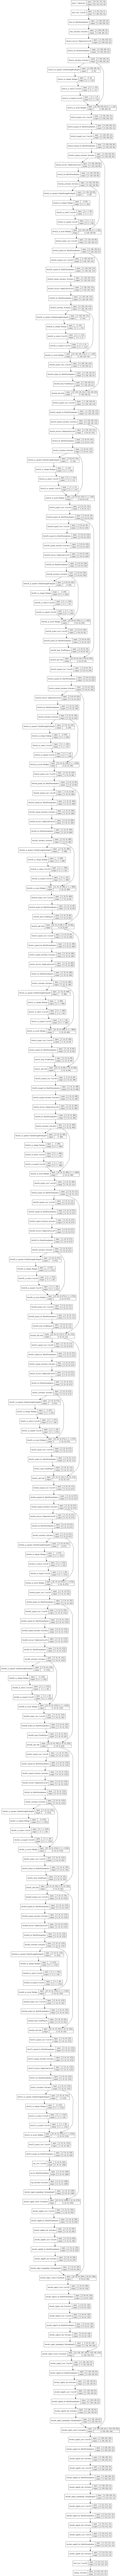

In [ ]:
# Plot the model for visualization of connections
tf.keras.utils.plot_model(model,show_shapes=True)

**AdaBelief Optimizer**<br>
Adabelief is a very recent optimizer is published in NeurIPS 2020 as a spotlight.<br>
Gradient descent methods can be categorized as either adaptive methods such as Adam where the learning rate is adapted based on frequency parameter is updated and momentum based such as SGD with momentum. Adabelief works on the intuition that the stepsize is adapted according to belief in the current gradient direction. The blue part in AdaBelief algo is the one that is different from Adam. Here gt is the gradient and mt is the prediction of gt. If they do not devate meaning gt is close to mt, then the update is large and if the deviation is large, then update is small. This inverse propotionality is because st is the term in the denominator in update rule

https://juntang-zhuang.github.io/adabelief/

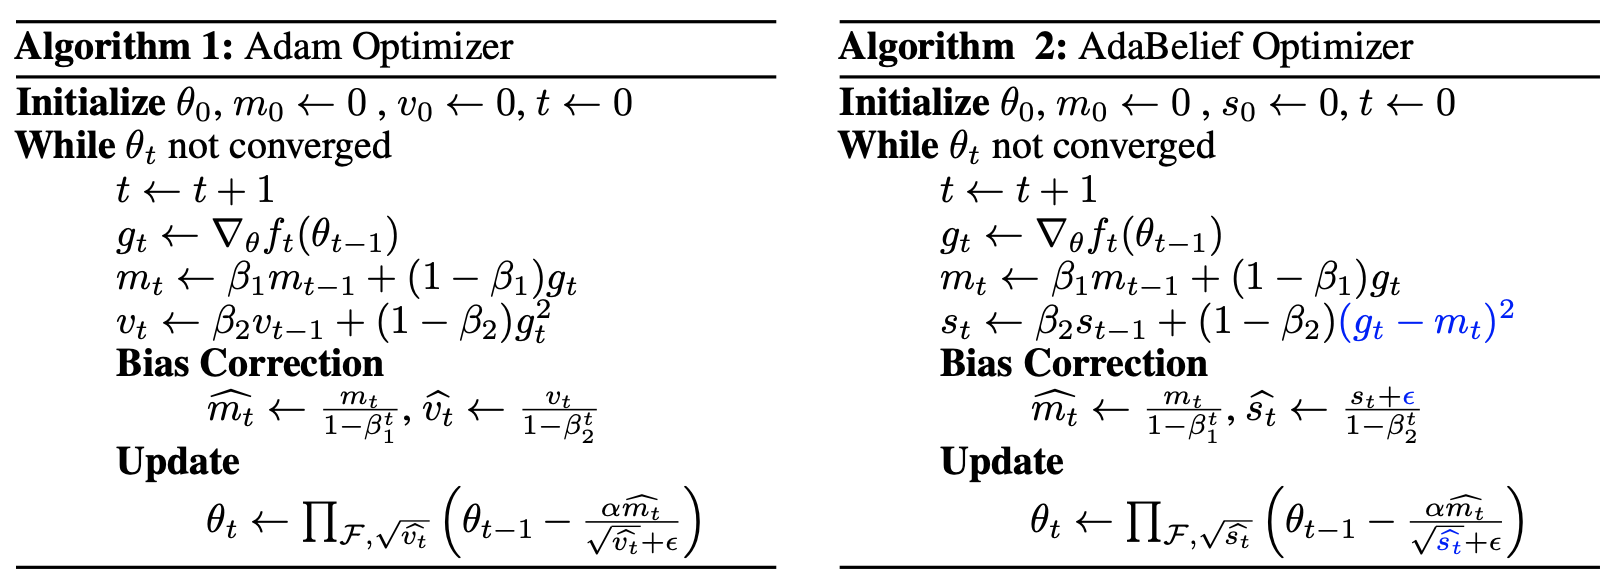

In [ ]:
# This is a new optimizer so prefered to keep hyperparameters as it is
from adabelief_tf import AdaBeliefOptimizer
optim = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)

# For loss, we combine two losses. 
# First one is Categorical cross entropy which is obvious choice for multiclass
# classisication setting as it is a likelihood based loss
# Jaccard loss is a metric for measuring the Intersection over Union
# Refer:https://en.wikipedia.org/wiki/Jaccard_index
# Intersection over Union means that the number of points that have same value/total no. of points
# Values for IoU range from 0-1 where one is best and zero is worst.

loss=sm.losses.cce_jaccard_loss

# Metrics to display while training
# IoU is a more interpretable score since its value is between 0-1 where 0 is 
# the worst case and 1 is the best case

metrics = [sm.metrics.iou_score,sm.metrics.f1_score]


model.compile(optim, loss, metrics)

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
Current version (0.1.0)  1e-14  supported          default: True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer



In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    train=True
   
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES
    
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES
    
) 

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
# check shapes for errors

assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

In [ ]:
valid_dataloader.__len__()

2993

In [ ]:
test_dataloader.__len__()

2824

In [ ]:
# tf.keras callbacks are used to perform actions at various stages of training.
# ModelCheckpoint is used to save the best model weights and we require weights 
# only not the structure, so it becomes standard choice
# Mode defines whats best, min or max as save best only is true
# Reduce LR on Plateau is a callback that modulates the learning rate based on
# what is being monitored
# Key Parameters include monitor which defines the metric to monitor, which is val_loss
# by default. It also contains factor that tells by how much to reduce the learning 
# rate. We can also set min_delta beyond which LR will not drop
# And there is a patience parameter that tells how many epochs before this epoch 
# the score has not improved to change delta.

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min',monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score',min_lr=0.000001,patience=2,)
]

In [ ]:
train_dataloader.__len__()

625

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=EPOCHS,validation_data=valid_dataloader,callbacks=callbacks )

Epoch 1/3
625/625 [==============================] - 9353s 15s/step - loss: 0.5888 - iou_score: 0.4411 - f1-score: 0.5232 - val_loss: 0.5014 - val_iou_score: 0.5200 - val_f1-score: 0.5822 - lr: 0.0010
Epoch 2/3
625/625 [==============================] - 678s 1s/step - loss: 0.4473 - iou_score: 0.5754 - f1-score: 0.6706 - val_loss: 0.4755 - val_iou_score: 0.5429 - val_f1-score: 0.6002 - lr: 0.0010
Epoch 3/3
625/625 [==============================] - 683s 1s/step - loss: 0.4205 - iou_score: 0.5999 - f1-score: 0.6927 - val_loss: 0.4709 - val_iou_score: 0.5473 - val_f1-score: 0.6036 - lr: 0.0010


**From above training, we can see that the training IoU is approx 0.6 (remember this is on only 5000 images due to resource constraints, whole dataset might give different results) and validation IoU is 0.54 after 3 epochs**

In [ ]:
import pandas as pd

In [ ]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'hist.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

**Here Lets see the final train, validation and test performace metrics as well as plot some images from test set**<br>
The images would not be that good since only trained for three epochs but with enough time and compute and use of full data can give good results

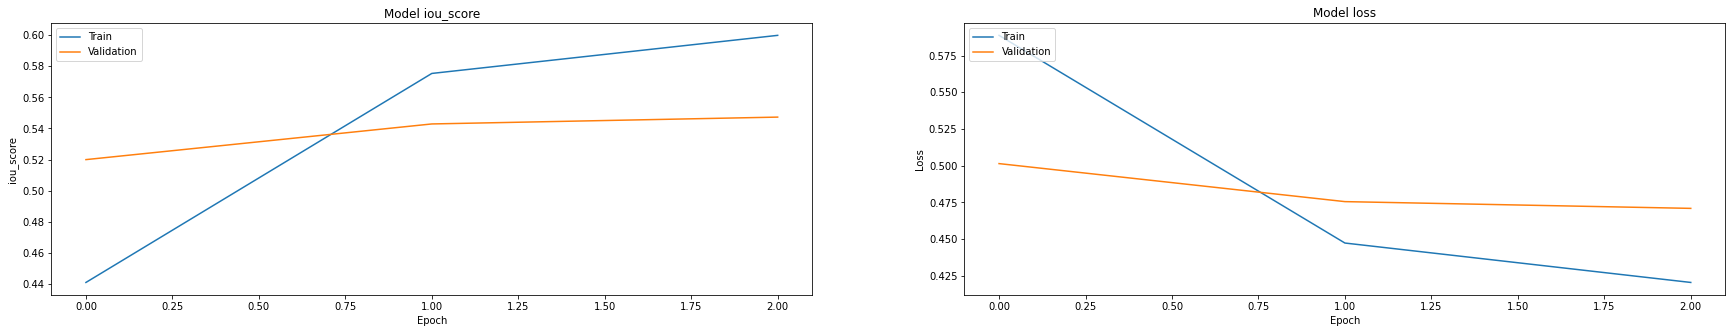

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

  **As mentioned earlier this plot is somewhat trivial because**

In [ ]:
model.evaluate(test_dataloader)

2824/2824 [==============================] - 3207s 1s/step - loss: 0.4706 - iou_score: 0.5476 - f1-score: 0.6039


[0.47062137722969055, 0.5476233959197998, 0.6039199829101562]

**Test IoU is 0.54 which is nearly the same as training and validation, so our model has somewhat generalized well**

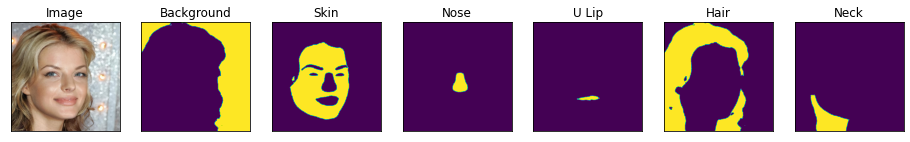

In [ ]:
# The predications seem reasonably well even  when trained on subset of original data
# My reasoning is because all the images where faces thus the variation in images,
# even though exists, was not as much as seen in say Imagenet or other datasets 
# That contain multiple objects of different scales
image,mask=test_dataset[10]

# Round because as I said earlier this can be thought of pixel wise classification
# And classification methods do select one value, in our case 0,1
# Less than 0.5 is 0 and greater than 0.5 is 1

pred=model.predict(image.reshape(1,512,512,3)).round()
visualize(image=image,
          background=pred[..., 0].squeeze(),
          skin=pred[..., 1].squeeze(),
          nose=pred[..., 2].squeeze(), 
          #eye_g=pred[..., 3].squeeze(),
          #l_eye=pred[..., 4].squeeze(), 
          #r_eye=pred[..., 5].squeeze(),
          #l_brow=pred[..., 6].squeeze(),
          #r_brow=pred[..., 7].squeeze(),
          #l_ear=pred[..., 8].squeeze(),
          #r_ear=pred[..., 9].squeeze(),
          #mouth=pred[..., 10].squeeze(), 
          u_lip=pred[..., 11].squeeze(), 
          #l_lip=pred[..., 12].squeeze(),
          hair=pred[..., 13].squeeze(),
          #hat=pred[..., 14].squeeze(),
          #ear_r=pred[..., 15].squeeze(),
          #neck_l=pred[..., 16].squeeze(),
          neck=pred[..., 17].squeeze(),
          #cloth=pred[..., 18].squeeze()
          
          
          )
